In [55]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import stats
from scipy.stats import norm

# ID 110809735 - AST443 Lab 0

Author: 110809735

Partners: 110941156 and 110869065

### (4.1.1)

The imaging camera used in this lab was the STL-1001 controlled with CCDSoft. The first order of business was to take calibration frames which did not require the camera to be mounted on the telescope. We connected the camera to CCDSoft and cooled it to $0^{\circ}C$. 

We took two types of calibration frames: bias frames and dark frames. The bias frames were taken first; these are zero second exposures with the internal shutter closed. Bias frames allow us to measure the inherent bias level of each pixel and the read noise.

At $0^{\circ }C$, we took a series of 10 bias frames. Let's check out one of the frames and analyze the distribution of counts across its pixels. 

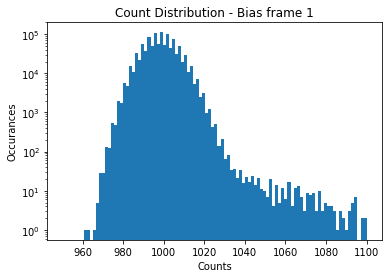

In [56]:
#opening the FIT of the first bias frame from 3.1.1
bias1 = fits.open('btm_31_biasframes.00000001.BIAS.FIT')
imd_bias1 = bias1[0].data  
countvals = imd_bias1.flatten()

#plotting a histogram of the counts
plt.hist(countvals,range=[950,1100],bins=100);
plt.yscale('log')
plt.xlabel('Counts')
plt.ylabel('Occurances')
plt.title('Count Distribution - Bias frame 1');

This is the first bias frame taken. The FIT file was flattened and we plot the resulting distribution of counts, as shown above. This distribution looks fairly Gaussian. Here, we have zoomed in to show the majority of the distribution, there are a few outliers at counts > 1,100 that will later be excluded through clipping. 

Since the distribution is normal, we can find its statistics:

In [57]:
#properties of the distribution
s_mean = np.mean(countvals)
s_median = np.median(countvals)
s_sd = np.std(countvals)
s_mode = stats.mode(countvals)[0][0]
print('mean   = ', '%.2f'%s_mean,' counts')
print('median = ','%.2f'%s_median,' counts')
print('mode   = ','%.2f'%s_mode,' counts')
print('standard deviation = ','%.2f'%s_sd,' counts')

mean   =  998.42  counts
median =  998.00  counts
mode   =  998.00  counts
standard deviation =  13.16  counts


A true Gaussian distribution curve has equivalent mean, median, and mode. For this frame's distribution, the median and mode are equivalent. The mean is slightly higher, likely because of the high-count outliers. Using this mean and standard deviation, we can fit and overlay a Gaussian on top of this distribution. This will allow us to cut count values that deviate.

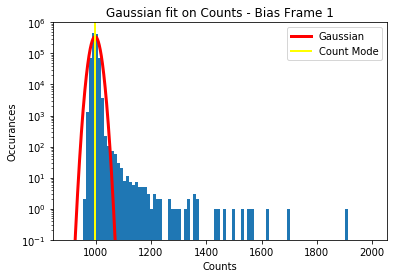

In [58]:
#fitting a gaussian to the single frame distribution
cmin = 900
cmax = 2000
nbins = 100
normalization=(cmax-cmin)/nbins*len(countvals[(countvals>=cmin)&(countvals<=cmax)])

mu = np.mean(countvals)
sd = np.std(countvals)
mode = stats.mode(countvals)[0][0]
xarr = np.linspace(cmin,cmax,nbins*100)
yarr = normalization*norm.pdf(xarr,loc=mu,scale=sd)  #the gaussian curve

plt.hist(countvals,range=[cmin,cmax],bins=nbins)
plt.yscale('log')
plt.ylim([0.1,1e6])
plt.plot(xarr,yarr,color='red',linewidth=3.0,label='Gaussian')
plt.xlabel('Counts')
plt.ylabel('Occurances')
plt.title('Gaussian fit on Counts - Bias Frame 1')
plt.axvline(x=mode,linewidth=2.0,color='yellow',label='Count Mode')
plt.legend(loc='best');

Here, the full distribution showing outliers is plotted. The red curve is the fitted Gaussian and the yellow line is positioned at the count distribution mode, intersecting the overlayed Gaussian. 

As mentioned, we wish to cut out counts that deviate from the Gaussian fit. We define the cut-off such that counts outside $\pm 3\sigma$ are clipped.

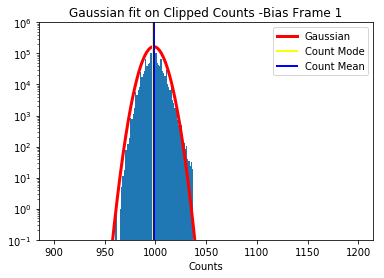

clipped mean =  998.37  counts
clipped standard deviation =  7.57  counts
fraction of pixels rejected =  0.000424


In [59]:
upcut = s_mean + 3*s_sd     # we define our cut as a 3-sigma clip
lowercut = s_mean - 3*s_sd
clippedvals = countvals[countvals<upcut]  #new array with outliers cut out

#replotting the Guassian with the clipped array 
cmin = 900
cmax = 1200
nbins = 100
normalization=(cmax-cmin)/nbins*len(countvals[(countvals>=cmin)&(countvals<=cmax)])

mu_c = np.mean(clippedvals)
sd_c = np.std(clippedvals)
mode = stats.mode(clippedvals)[0][0]
xarr = np.linspace(cmin,cmax,nbins*10)
yarr = normalization*norm.pdf(xarr,loc=mu_c,scale=sd_c)

plt.hist(clippedvals,range=[925,1050],bins=nbins)
plt.yscale('log')
plt.ylim([0.1,1e6])
plt.plot(xarr,yarr,color='red',linewidth=3.0,label='Gaussian')
plt.axvline(x=mode,linewidth=2.0,color='yellow',label='Count Mode')
plt.axvline(x=mu_c,linewidth=2.0,color='blue',label='Count Mean')
plt.xlabel('Counts')
plt.legend(loc='best')
plt.title('Gaussian fit on Clipped Counts -Bias Frame 1')
plt.show()

# stats of the clipped distribution
print('clipped mean = ', '%.2f'%mu_c, ' counts')
print('clipped standard deviation = ', '%.2f'%sd_c, ' counts')

rejected_frac = 1-len(clippedvals)/len(countvals)
print('fraction of pixels rejected = ','%.6f'%rejected_frac)

Here we plot the count distribution of the $3 \sigma$ clipped distribution. Overlayed by the red curve is a new Gaussian fitted to the clipped distribution. We see that the clipped distribution matches the Gaussian very well. The new mean of $998.37$ counts is now closer to the mode; these are represented by the blue and yellow lines, respectively. The mean decreased $0.005 \%$ as a result of the clip. A more significant change occured with the standard deviation, which decreased by $42.5 \%$. 

The clipping only cut out a fraction $0.000424$ of the total pixels. This is an insignificant amount, so we do not need to worry about this clip giving biased data, no pun intended. 

### (4.1.2)

Each CCD has an intrinsic read noise. This can be calculated directly from the bias frame standard deviation and the camera's intrinsic gain. 

In [60]:
#the CCD's gain is given in the header file
header = bias1[0].header
gain = header['EGAIN']  #gain = N_elec / N_count

#using the gain, we can calculate the read noise as a count of electrons
read_elec = gain*sd_c   #calculated using the s.d. of clipped distribution
print('read noise = ','%.2f'%read_elec, ' electrons')

read noise =  15.59  electrons


Based on the single frame standard deviation, we calculate the read noise to be $15.59 ~ e^-$. The spec-sheet of the STL-1001 CCD reports a read noise of $14.8 ~e^-$, which is $.05\%$ lower than our measured value. 

The most likely reason that our measured read noise is higher than the reported value is that our calculated value was based off only one bias frame. A combination of a series of bias frames will have a lower standard deviation than any individual frame, and a lower read noise value as a result. Further, we do not know how long this CCD has been in use or how it has been cared for and maintained. Any age and damage could have had an adverse affect on the camera resulting in higher read noise. 

### (4.1.3)
As mentioned, one way of reducing the effect of read noise is to construct a series of bias frames. This is known as a master bias frame. To construct this, we take our series of 10 bias frames taken in the lab and average them. Each frame was taken in succession at the same temperature. This master frame will provide a better indication of each pixel's bias level. 

Master Bias frame distribution stats (units of counts);
master mean  =  998.69 , single frame mean =  998.42
master s.dev. =  11.25 , single frame s.dev. =  13.16
master s.dev. / single s.dev. = 0.855


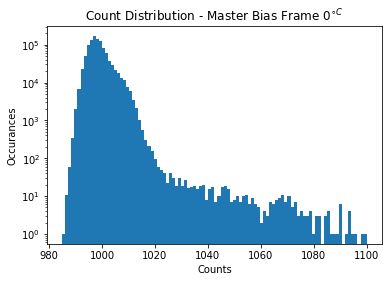

In [61]:
# opening the remaining bias frame FITs
bias2 = fits.open('btm_31_biasframes.00000002.BIAS.FIT')
bias3 = fits.open('btm_31_biasframes.00000003.BIAS.FIT')
bias4 = fits.open('btm_31_biasframes.00000004.BIAS.FIT')
bias5 = fits.open('btm_31_biasframes.00000005.BIAS.FIT')
bias6 = fits.open('btm_31_biasframes.00000006.BIAS.FIT')
bias7 = fits.open('btm_31_biasframes.00000007.BIAS.FIT')
bias8 = fits.open('btm_31_biasframes.00000008.BIAS.FIT')
bias9 = fits.open('btm_31_biasframes.00000009.BIAS.FIT')
bias10 = fits.open('btm_31_biasframes.00000010.BIAS.FIT')

# each is read into an array
imd_bias2 = bias2[0].data
imd_bias3 = bias3[0].data
imd_bias4 = bias4[0].data
imd_bias5 = bias5[0].data
imd_bias6 = bias6[0].data
imd_bias7 = bias7[0].data
imd_bias8 = bias8[0].data
imd_bias9 = bias9[0].data
imd_bias10 = bias10[0].data

#now creading an average of the series
all_img = [imd_bias10,imd_bias9,imd_bias8,imd_bias7,imd_bias6,imd_bias5,imd_bias4,imd_bias3,imd_bias2,imd_bias1]
avg = np.mean(all_img,axis=0)

#we can now calculate properties of the combined frames
mastercounts = avg.flatten()
#masterclip = mastercounts[mastercounts<1018]
m_mean = np.mean(mastercounts)
m_sd = np.std(mastercounts)

#rej_frac = 1-len(masterclip)/len(mastercounts)

plt.hist(mastercounts,range=[985,1100],bins=100);  ## include hist of master bias vvv
plt.yscale('log')
plt.xlabel('Counts')
plt.ylabel('Occurances')
plt.title('Count Distribution - Master Bias Frame $0^{\circ C}$')
plt.savefig('bias_dist_T0.png')   # Saving figure for use in report

print('Master Bias frame distribution stats (units of counts);')
print('master mean  = ','%.2f'%m_mean,', single frame mean = ','%.2f'%s_mean)
print('master s.dev. = ','%.2f'%m_sd,', single frame s.dev. = ','%.2f'%s_sd)
print('master s.dev. / single s.dev. =', '%.3f'%(m_sd/s_sd))

Here, we present the statistics of the average combined master frame, with no clipping. The stats of the single bias frame, as calculated previously, are repeated for comparison.

The mean of the average combined master frame, with no clipping, comes to 998.69 counts. This is a $0.03\%$ increase from the single bias frame mean.

The standard deviation of the unclipped master frame is 11.25 counts. Comparing this to the single frame standard deviation, it represents a decrease by a factor of $\sigma_{master} / \sigma_{single} = 0.855$. While it is a decrease, it is not as substantial as expected from statistical theory which suggests the uncertainty with $N$ samples goes as $1/\sqrt{N}$. With $N=10$ frames, this corresponds to a factor of $0.316$. Nevertheless, since the read noise is directly proportional to the standard deviation, creating the master frame indeed reduced the read noise. 

Let's consider the effect of clipping the master frame as we did the single frame and reexamine the comparison.

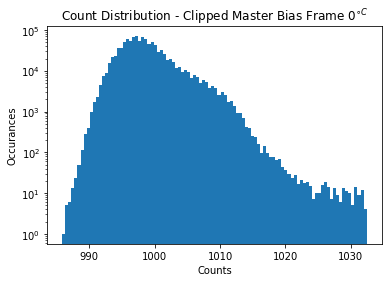

Clipped distribution values (units of counts);
master mean =  998.63 , single mean =  998.37
master s.dev. =  3.88 , single s.dev. =  7.57
master s.dev. / single s.dev. = 0.513
fraction rejected =  0.00049


In [62]:
# let's also compare clipped stats
# again we use a 3-sigma clip
upclip = m_mean + 3*m_sd
lowclip = m_mean - 3*m_sd

masterclip = mastercounts[(mastercounts<=upclip)&(mastercounts>=lowclip)]
cm_mean = np.mean(masterclip)
cm_sd = np.std(masterclip)

plt.hist(masterclip,bins=100)
plt.yscale('log')
plt.xlabel('Counts')
plt.ylabel('Occurances')
plt.title('Count Distribution - Clipped Master Bias Frame $0^{\circ C}$')
plt.savefig('clip_bias_dist_T0.png')
plt.show()

print('Clipped distribution values (units of counts);')
print('master mean = ','%.2f'%cm_mean,', single mean = ','%.2f'%mu_c)
print('master s.dev. = ','%.2f'%cm_sd,', single s.dev. = ','%.2f'%sd_c)
print('master s.dev. / single s.dev. =', '%.3f'%(cm_sd/sd_c))
print('fraction rejected = ','%.5f'%(1-len(masterclip)/len(mastercounts)))

After the clip, the master mean is again about a $0.03\%$ increase from the clipped single frame mean. The clipping hardly impacted the mean, though, only decreasing it by $0.006 \%$ from the unclipped value.

On the contrary, the clipped master frame standard deviation decreased by $66\%$ from the unclipped value. When comparing this to the clipped single frame, it is a decrease by factor $\sigma_{master} / \sigma_{single} = 0.513$. This is closer to the predicted $1/\sqrt{N}$ factor than the unclipped case.  

As with the single frame case, the cut was defined by $\pm 3 \sigma$. As a result, a fraction of $0.00049$ of pixels were rejected from the master bias frame. 

### (4.1.4) 
The objective of creating a master frame from a series of bias frames was to reduce the effect of read noise in each individual frame. Another way of reducing read noise is to cool the camera to a lower temperature. At the lower temperature, electrons within the internal semiconductor of the CCD will have lower energy. As a result, a fewer number will jump to the conduction band and give false counts due to their thermal energy and not an incoming photon. This is more applicable to the dark current, discussed later in this analysis, but can effect read noise as well.

To test this, the camera was cooled to $-13^{\circ C}$ and a single bias frame was taken.

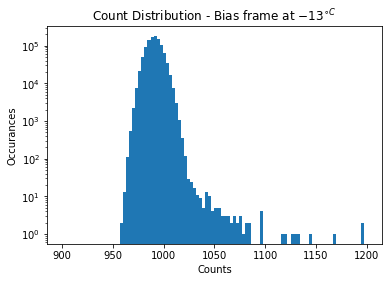

In [63]:
#opening the bias frame taken at T = -13 C
newTbias = fits.open('btm_314.00000000.BIAS.FIT')
imd_newTbias = newTbias[0].data
newTcounts = imd_newTbias.flatten()

plt.hist(newTcounts,range=[900,1200],bins=100)
plt.yscale('log')
plt.xlabel('Counts')
plt.ylabel('Occurances')
plt.title('Count Distribution - Bias frame at $-13^{\circ C}$')
plt.savefig('bias_dist_T13.png')    # Saving figure for use in report

The cooled frame distribution exhibits Gaussian-like behavior with a few outliers at high count values. We will use the same 3-sigma clip criteria.

Cooled Bias Frame stats:
mean =  990.28  counts
s.d. =  9.47  counts


Clipped Cooled Bias Frame stats:
mean =  990.26  counts
s.d. =  7.07  counts
fraction of pixels rejected =  0.000364
read noise =  14.56  electrons


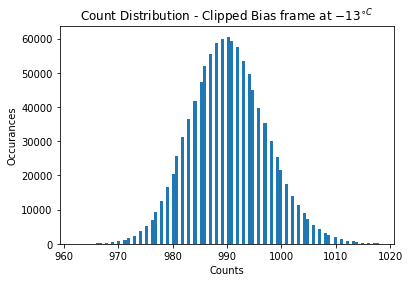

In [64]:
# clipping the cooled bias frame
cool_mean = np.mean(newTcounts)
cool_sd = np.std(newTcounts)
upclip = cool_mean + 3*cool_sd
lowclip = cool_mean - 3*cool_sd

print('Cooled Bias Frame stats:')
print('mean = ','%.2f'%np.mean(newTcounts), ' counts')
print('s.d. = ','%.2f'%np.std(newTcounts), ' counts')
print('\n')

newTclipvals = newTcounts[(newTcounts<=upclip)&(newTcounts>=lowclip)]

# determining the read noise 
newTheader = newTbias[0].header
gain = newTheader['EGAIN']
read_elec = gain*np.std(newTclipvals)

print('Clipped Cooled Bias Frame stats:')
print('mean = ','%.2f'%np.mean(newTclipvals), ' counts')
print('s.d. = ','%.2f'%np.std(newTclipvals), ' counts')
print('fraction of pixels rejected = ', '%.6f'%(1-len(newTclipvals)/len(newTcounts)))
print('read noise = ','%.2f'%read_elec, ' electrons')

plt.hist(newTclipvals,bins=100);
plt.title('Count Distribution - Clipped Bias frame at $-13^{\circ C}$');
plt.xlabel('Counts');
plt.ylabel('Occurances');
plt.savefig('clip_bias_dist_T13.png')

After performing a $3\sigma$ clip, the bias frame taken at $-13^{\circ C}$ had a mean of 990.26 counts. This is a $0.8\%$ decrease from the mean of the bias frame at $0^{\circ C}$. The standard deviation also decreased as a result of cooling the camera. The clipped, cooled bias frame has a standard deviation of $7.07$ counts, a $7\%$ decrease from the $0^{\circ C}$ frame value. 

A direct consequence of the standard deviation decreasing is that the read noise also decreases. The bias frame taken at $-13^{\circ C}$ has a read noise of $14.56 e^-$. The frame at $0^{\circ C}$ had a read noise of $15.59 e^-$, so cooling the camera resulted in a $6.6 \%$ decrease in read noise. This makes sense, as the electrons within the CCD have less average thermal energy when the camera is cooled. 

Finally, the cooled bias frame had a smaller fraction of outlier pixels, defined by the $3\sigma$ clip. At $0^{\circ C}$, the clip rejected $0.0424\%$ of pixels, while at $-13^{\circ C}$ only $0.0364\%$ of pixels were rejected. This is also a consequence of the cooling; electrons in the cooler camera have less thermal energy so there will be less outliers at high count values due to electrons jumping to the conduction band caused by their thermal energy. 

### (4.2.1)

Now that we have measured the read noise within our CCD, we can move on to measuring the dark current. The dark current is a measure of how many counts on each pixel is a result of the thermal energy of electrons, rather than an incident photon. This is measured with a dark frame, an exposure with a closed shutter. 

Just as we created a master bias frame out of a series of bias frames, the same can be done to create a master dark frame. A master dark frame must be composed of dark frames each of the same exposure time. With the CCD at $0^{\circ C}$, we took a series of ten dark frames with an exposure time of 30s. We can then median combine these frames into our master dark frame and examine its distribution and properties.

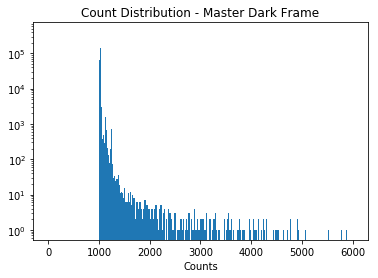

mean =  1025.84  counts
standard deviation =  156.95  counts
median =  1020.50  counts
mode =  1019.00  counts


In [65]:
#opening the series of 10 dark frames
df1 = fits.open('btm_313_darkframes.00000001.DARK.FIT')
df2 = fits.open('btm_313_darkframes.00000002.DARK.FIT')
df3 = fits.open('btm_313_darkframes.00000003.DARK.FIT')
df4 = fits.open('btm_313_darkframes.00000004.DARK.FIT')
df5 = fits.open('btm_313_darkframes.00000005.DARK.FIT')
df6 = fits.open('btm_313_darkframes.00000006.DARK.FIT')
df7 = fits.open('btm_313_darkframes.00000007.DARK.FIT')
df8 = fits.open('btm_313_darkframes.00000008.DARK.FIT')
df9 = fits.open('btm_313_darkframes.00000009.DARK.FIT')
df10 = fits.open('btm_313_darkframes.00000010.DARK.FIT')

im_df1 = df1[0].data
im_df2 = df2[0].data
im_df3 = df3[0].data
im_df4 = df4[0].data
im_df5 = df5[0].data
im_df6 = df6[0].data
im_df7 = df7[0].data
im_df8 = df8[0].data
im_df9 = df9[0].data
im_df10 = df10[0].data

all_dark = [im_df10,im_df9,im_df8,im_df7,im_df6,im_df5,im_df4,im_df3,im_df2,im_df1]
comd = np.median(all_dark,axis=0)
darkcounts = comd.flatten()

plt.hist(darkcounts,range=[0,6000],bins=1000)
plt.yscale('log')
plt.xlabel('Counts')
plt.title('Count Distribution - Master Dark Frame')
plt.savefig('dark_dist_T0.png')
plt.show()

mdf_mean = np.mean(darkcounts)
mdf_sd = np.std(darkcounts)
mdf_med = np.median(darkcounts)
mdf_mode = stats.mode(darkcounts)[0][0]

print('mean = ','%.2f'%mdf_mean, ' counts')
print('standard deviation = ','%.2f'%mdf_sd, ' counts')
print('median = ','%.2f'%mdf_med, ' counts')
print('mode = ','%.2f'%mdf_mode, ' counts')

The above histogram plots the counts of our master dark frame, which we see is not quite Gaussian. The distribution is heavily one-sided toward high count values. This makes sense, since the dark current counts are proportional to the exposure time, making it more unlikely to have count values lower than the mode. 

The mean of this distribution is $1025.84$ counts, the median is $1020.5$ counts, and the mode is $1019.0$ counts. Since the distribution is heavily one-sided, the mode best describes the true value. The standard deviation is $156.95$ counts. Since the distribution is one-sided, we can not accurately fit a Gaussian using the mean. Therefore, we will define our cut using the mode. We again use a 3$\sigma$ clip.

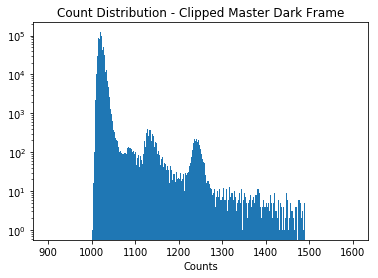

mean =  1023.45  counts
standard deviation =  20.32  counts
median =  1020.50  counts
mode =  1019.00  counts
fraction rejected =  0.0012


In [66]:
cutval = mdf_mode + 3*mdf_sd
darkclipcounts = darkcounts[darkcounts<=cutval]

plt.hist(darkclipcounts,range=[900,1600],bins=500)
plt.yscale('log')
plt.xlabel('Counts')
plt.title('Count Distribution - Clipped Master Dark Frame')
plt.savefig('clip_dark_dist_T0.png')
plt.show()

#determining the new stats
cmdf_mean = np.mean(darkclipcounts)
cmdf_sd = np.std(darkclipcounts)
cmdf_med = np.median(darkclipcounts)
cmdf_mode = stats.mode(darkclipcounts)[0][0]

print('mean = ','%.2f'%cmdf_mean, ' counts')
print('standard deviation = ','%.2f'%cmdf_sd, ' counts')
print('median = ','%.2f'%cmdf_med, ' counts')
print('mode = ','%.2f'%cmdf_mode, ' counts')

rej_frac = 1 - len(darkclipcounts)/len(darkcounts)
print('fraction rejected = ','%.4f'%rej_frac)

Here we plot the master dark frame count distribution after the $3\sigma$ clip. As a result of the clip, the mean decreased to $1023.45$ counts while the median and mode remain unchanged at $1020.5$ and $1019$ counts, respectively. The standard deviation decreased by $87\%$ to $20.32$ counts. 

The standard deviation changed most significantly after the clipping. The clipping rejected a fraction $0.0012$ of the total pixels, so $99.88\%$ of the pixels remain in the distribution. The outliers that were clipped are the hot pixels; under this clip there are $1,258$ hot pixels. 

### (4.2.2)

The master dark frame was constructed from a series of 10 dark frames. Let's see how it compares to one of its constituent frames. We'll open the second dark frame taken and $3 \sigma$ clip it. 

In [67]:
d2counts = im_df2.flatten()
d2mode = stats.mode(d2counts)[0][0]
d2sd = np.std(d2counts)

cutval = d2mode + 3*d2sd
d2clipcounts = d2counts[d2counts<=cutval]

d2c_mean = np.mean(d2clipcounts)
d2c_sd = np.std(d2clipcounts)
d2c_median = np.median(d2clipcounts)
d2c_mode = stats.mode(d2clipcounts)[0][0]

print('Clipped Dark Frame 2 stats:')
print('mean   = ','%.2f'%d2c_mean, ' counts')
print('median = ','%.2f'%d2c_median, ' counts')
print('mode   = ','%.2f'%d2c_mode, ' counts')
print('standard deviation = ','%.2f'%d2c_sd, ' counts')


rej_frac = 1 - len(d2clipcounts)/len(d2counts)
print('fraction rejected = ','%.4f'%rej_frac)

Clipped Dark Frame 2 stats:
mean   =  1023.43  counts
median =  1021.00  counts
mode   =  1020.00  counts
standard deviation =  21.58  counts
fraction rejected =  0.0012


The individual clipped frame has a mean of $1023.43$ counts, which is nearly identical to the clipped master dark frame. The median and mode are nearly the same as the corresponding master dark values, as well. 

The clipped individual frame has a standard deviation of $21.58$ counts, higher than the master frame. Since the master frame was constructed from a series of $10$ individual frames, its standard deviation ought to have decreased by a factor $1/\sqrt{10}$ from that of the individual frames. This explains why the individual frame has a higher standard deviation, although by a lesser factor. 

Further, the clipping of the individual frame resulted in a fraction $0.0012$ of the total pixels being rejected. This is identical to the fraction of pixels rejected in clipping the master dark frame. The fact that these are identical makes sense for two reasons. First, if the CCD does have any bad pixels, the property of being a bad pixel is not likely to change nor is it likely for a good pixel to break down and become bad on the short timescale of our successive exposures. Second, since the exposures were all taken in succession with 30s exposure time, this is a short enough time-scale that any random fluctuations causing a good pixel to appear 'bad' would be present throughout the series and would not dissipate during the series. 

### (4.2.3-4)

The purpose of taking a dark frame is to get a measure of the dark current. Taking the exposure with the shutter closed ensures that the counts measured are false counts, since no signal is hitting the camera. However, both the dark current and the intrinsic bias contributes to these false count values. To measure only the dark current, this bias must be subtracted. 

Dark current is caused by electrons jumping into the conduction band due to their thermal energy. If the electrons are given more time to do so, more electrons will be able to make the jump. Therefore, the dark current is directly proportional to the exposure time. To test this, we took a series of dark frames with increasing exposure times: 10s, 20s, 30s, 60s, 90s, 120s, 180s, 240s, and 300s. Each was taken with the camera at a temperature of $0^{\circ C}$. 

To isolate the dark current in each dark frame, we subtract the master bias from the dark exposure. Then, the counts in each pixel measures only the dark current. These are then $3\sigma$ clipped based on that exposure's mean so that a Guassian distribution fits the data. 

In [68]:
#subtracting the master bias from each dark exposure (from 3.1.2?)
# the master is avg or mastercounts

cdfexp_meanvals = []  #list of means for each exp time
cdfexp_meanunc  = []  #uncertainties on the mean

#frames from 3.1.2:
dfexp1 = fits.open('btm_312_darkframes.00000001.DARK.FIT') #10s
dfexp1dat = dfexp1[0].data
dfexp1counts = dfexp1dat.flatten() - mastercounts
mean = np.mean(dfexp1counts)
sd = np.std(dfexp1counts)
cmin = mean - 3*sd
if cmin < 0: cmin = 0
cmax = mean + 3*sd
cdfexp1counts = dfexp1counts[(dfexp1counts<=cmax)&(dfexp1counts>=cmin)]
cdfexp_meanvals.append(np.mean(cdfexp1counts))
cdfexp_meanunc.append(np.std(cdfexp1counts)/np.sqrt(9))

dfexp2 = fits.open('btm_312_darkframes.00000002.DARK.FIT') #20s
dfexp2dat = dfexp2[0].data
dfexp2counts = dfexp2dat.flatten() - mastercounts
mean = np.mean(dfexp2counts)
sd = np.std(dfexp2counts)
cmin = mean - 3*sd
if cmin < 0: cmin = 0
cmax = mean + 3*sd
cdfexp2counts = dfexp2counts[(dfexp2counts<=cmax)&(dfexp2counts>=cmin)]
cdfexp_meanvals.append(np.mean(cdfexp2counts))
cdfexp_meanunc.append(np.std(cdfexp2counts)/np.sqrt(9))

dfexp3 = fits.open('btm_312_darkframes.00000003.DARK.FIT') #30s
dfexp3dat = dfexp3[0].data
dfexp3counts = dfexp3dat.flatten() - mastercounts
mean = np.mean(dfexp3counts)
sd = np.std(dfexp3counts)
cmin = mean - 3*sd
if cmin < 0: cmin = 0
cmax = mean + 3*sd
cdfexp3counts = dfexp3counts[(dfexp3counts<=cmax)&(dfexp3counts>=cmin)]
cdfexp_meanvals.append(np.mean(cdfexp3counts))
cdfexp_meanunc.append(np.std(cdfexp3counts)/np.sqrt(9))

dfexp4 = fits.open('btm_312_darkframes.00000004.DARK.FIT') #1min
dfexp4dat = dfexp4[0].data
dfexp4counts = dfexp4dat.flatten() - mastercounts
mean = np.mean(dfexp4counts)
sd = np.std(dfexp4counts)
cmin = mean - 3*sd
if cmin < 0: cmin = 0
cmax = mean + 3*sd
cdfexp4counts = dfexp4counts[(dfexp4counts<=cmax)&(dfexp4counts>=cmin)]
cdfexp_meanvals.append(np.mean(cdfexp4counts))
cdfexp_meanunc.append(np.std(cdfexp4counts)/np.sqrt(9))

dfexp5 = fits.open('btm_312_darkframes.00000005.DARK.FIT') #1.5 min
dfexp5dat = dfexp5[0].data
dfexp5counts = dfexp5dat.flatten() - mastercounts
mean = np.mean(dfexp5counts)
sd = np.std(dfexp5counts)
cmin = mean - 3*sd
if cmin < 0: cmin = 0
cmax = mean + 3*sd
cdfexp5counts = dfexp5counts[(dfexp5counts<=cmax)&(dfexp5counts>=cmin)]
cdfexp_meanvals.append(np.mean(cdfexp5counts))
cdfexp_meanunc.append(np.std(cdfexp5counts)/np.sqrt(9))

dfexp6 = fits.open('btm_312_darkframes.00000006.DARK.FIT') #2min
dfexp6dat = dfexp6[0].data
dfexp6counts = dfexp6dat.flatten() - mastercounts
mean = np.mean(dfexp6counts)
sd = np.std(dfexp6counts)
cmin = mean - 3*sd
if cmin < 0: cmin = 0
cmax = mean + 3*sd
cdfexp6counts = dfexp6counts[(dfexp6counts<=cmax)&(dfexp6counts>=cmin)]
cdfexp_meanvals.append(np.mean(cdfexp6counts))
cdfexp_meanunc.append(np.std(cdfexp6counts)/np.sqrt(9))

dfexp7 = fits.open('btm_312_darkframes.00000007.DARK.FIT') #3 min
dfexp7dat = dfexp7[0].data
dfexp7counts = dfexp7dat.flatten() - mastercounts
mean = np.mean(dfexp7counts)
sd = np.std(dfexp7counts)
cmin = mean - 3*sd
if cmin < 0: cmin = 0
cmax = mean + 3*sd
cdfexp7counts = dfexp7counts[(dfexp7counts<=cmax)&(dfexp7counts>=cmin)]
cdfexp_meanvals.append(np.mean(cdfexp7counts))
cdfexp_meanunc.append(np.std(cdfexp7counts)/np.sqrt(9))

dfexp8 = fits.open('btm_312_darkframes.00000008.DARK.FIT') #4min
dfexp8dat = dfexp8[0].data
dfexp8counts = dfexp8dat.flatten() - mastercounts
mean = np.mean(dfexp8counts)
sd = np.std(dfexp8counts)
cmin = mean - 3*sd
if cmin < 0: cmin = 0
cmax = mean + 3*sd
cdfexp8counts = dfexp8counts[(dfexp8counts<=cmax)&(dfexp8counts>=cmin)]
cdfexp_meanvals.append(np.mean(cdfexp8counts))
cdfexp_meanunc.append(np.std(cdfexp8counts)/np.sqrt(9))

dfexp9 = fits.open('btm_312_darkframes.00000009.DARK.FIT') #5min
dfexp9dat = dfexp9[0].data
dfexp9counts = dfexp9dat.flatten() - mastercounts
mean = np.mean(dfexp9counts)
sd = np.std(dfexp9counts)
cmin = mean - 3*sd
if cmin < 0: cmin = 0
cmax = mean + 3*sd
cdfexp9counts = dfexp9counts[(dfexp9counts<=cmax)&(dfexp9counts>=cmin)]
cdfexp_meanvals.append(np.mean(cdfexp9counts))
cdfexp_meanunc.append(np.std(cdfexp9counts)/np.sqrt(9))

The dark current is measured in each exposure's count values and depends on the exposure time. To get a better understanding of their relationship, we plot the mean versus the exposure time. 

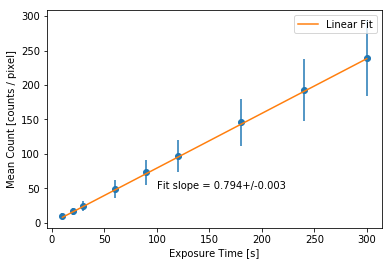

In [69]:
cdfexp_times = [10,20,30,60,90,120,180,240,300]
plt.scatter(cdfexp_times,cdfexp_meanvals)
plt.errorbar(cdfexp_times,cdfexp_meanvals,yerr=cdfexp_meanunc,linestyle='None')
plt.xlabel('Exposure Time [s]')
plt.ylabel('Mean Count [counts / pixel]')

linfit, V = np.polyfit(cdfexp_times,cdfexp_meanvals,1,cov=True) #linfit is parameters, V is covariant matrix
dark_current = linfit[0]  #dark current in counts per pix per sec
dark_current_err = np.sqrt(V[0][0])
y = [dark_current*x for x in cdfexp_times]
plt.plot(cdfexp_times,y, label='Linear Fit')
plt.legend(loc='best')
plt.savefig('dark_current_fit_T0.png')
text = 'Fit slope = ' + str('%.3f'%dark_current) + '+/-' + str('%.3f'%dark_current_err)
plt.text(100,50,text);

We see that the mean count is near perfectly linear with the exposure time. The error bars indicate the uncertainty on the mean for each dark frame. These points can be fitted very well with a first-order polynomial, as shown by the orange line. The slope of this linear regression gives the dark current in units of counts per pixel per second. To get this in units of electrons per pixel per second, we simply multiply by the gain.

In [70]:
# converting dark current to electrons per pix per sec
dark_current_elec = dark_current*gain
dark_current_elec_err = dark_current_err*gain
val = '(' + str('%.3f'%dark_current_elec) + ' +/- ' + str('%.3f'%dark_current_elec_err) +')'
print('Dark Current = ',val,' electrons/pixel/s')

Dark Current =  (1.635 +/- 0.006)  electrons/pixel/s


### (4.2.5)

Since dark current is caused by thermally energetic electrons within the CCD, cooling the camera ought to reduce the dark current. To test this, a dark frame was taken at $-13^{\circ} C$ with an exposure of 300s, which was the longest exposure time used at $0^{\circ} C$. 

The bias frame that was also taken at $-13^{\circ} C$ can be subtracted to isolate the dark current. Then, we $\sigma$ clip and measure the mean and standard deviation as before. To see how this matches up with the frames at $0^{\circ} C$, we plot this frame on the same mean/exposure time axes.

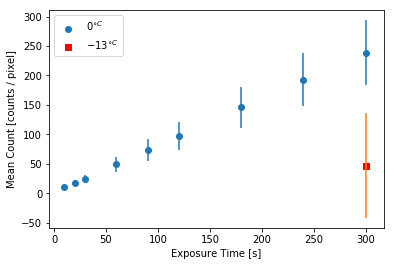

In [71]:
#opening the dark frame taken for T = -13 deg C
lowTdf = fits.open('btm_314.00000001.DARK.FIT')
lowTdfdat = lowTdf[0].data
lowTdfcounts = lowTdfdat.flatten() - newTcounts
lowTmean = np.mean(lowTdfcounts)
lowTsd = np.std(lowTdfcounts)
cmin = lowTmean - 3*lowTsd
if cmin < 0: cmin = 0
cmax = lowTmean + 3*lowTsd
clowTdfcounts = lowTdfcounts[(lowTdfcounts<=cmax)&(lowTdfcounts>=cmin)]
clowTmean = np.mean(clowTdfcounts)
clowTsd = np.std(clowTdfcounts)
clowTexp =  300 # [s] -> 5 min exposure time
clowTmeanunc = clowTsd 

#plotting this point on the mean vs exp time plot
plt.scatter(cdfexp_times,cdfexp_meanvals,label='$0^{\circ C}$')
plt.scatter(clowTexp,clowTmean,marker='s',color='red',label='$-13^{\circ C}$')
plt.errorbar(cdfexp_times,cdfexp_meanvals,yerr=cdfexp_meanunc,linestyle='None')
plt.errorbar(clowTexp,clowTmean,yerr=clowTmeanunc,linestyle='None')
plt.xlabel('Exposure Time [s]')
plt.ylabel('Mean Count [counts / pixel]')
plt.legend(loc='best')
plt.savefig('dark_current_T13.png')

We see that the mean for $-13^{\circ C}$ is much lower than the $0^{\circ C}$ value at the same exposure time. While this meets our expectations that lowering the temperature will reduce the dark current, we must actually calculate the dark current at this lower temperature to make a valid conclusion. 

In order to perform a linear regression on the $-13^{\circ C}$ data, another point is needed. We will choose to use the origin. This is a valid choice to use since there should be no dark current with zero exposure time as the thermal electrons have no time to make the jump. With these two points, we can calculate the slope between them and convert it to the dark current at $-13^{\circ C}$. 

In [72]:
#to estimate the dark current for the lower T value, assume that
#  there is another point at the origin (mean = 0, exposure = 0)
#  based on the assumption that with zero exposure time, there won't be any
#  time for dark current to matter
x = [0, clowTexp]
y = [0, clowTmean]
lowT_fit = np.polyfit(x,y,1) #can't find cov matrix since only 2 data points
lowT_darkcurrent = lowT_fit[0]
lowT_dc_elec = lowT_darkcurrent*gain

print('When camera is cooled to $-13^\circ C$ , ')
print('Dark Current = ','%.3f'%lowT_dc_elec,' electrons/pixel/s')

When camera is cooled to $-13^\circ C$ , 
Dark Current =  0.322  electrons/pixel/s


When the camera is at a temperature setting of $0^{\circ C}$, we calculate the dark current to be $1.635$ electrons/pixel/s. Cooling the camera down further to $-13^{\circ C}$ causes the dark current to decrease by $80.3\%$ to a value of $0.322$ electrons/pixel/s. Since only two data points were used for this fit at $-13^{\circ} C$, no uncertainty could be calculated for the dark current using this fitting method as it uses a covariance matrix.

When the CCD is at a lower temperature, the electrons within it will have a lower thermal energy, on average. Therefore, less electrons will have the necessary thermal energy to make the jump into the conduction band and give a false count. This translates directly to a lower dark current, as validated by our calculations.

### (4.3.1)

The previous sections have dealt with calibrating for read noise and dark current, two sources which contribute false counts to our science images. This would be the end of calibration if we had a uniformly sensitive camera. In reality, this is not the case as the sensitivity varies across the pixels on the CCD. This will cause different pixels to give a count different than their neighboring pixels, despite receiving the same incident signal. 

To correct for non-uniform sensitivity across our CCD, we utilize a flat-field. A flat-field is an image of a uniformly illuminated surface or plane. Since it is uniformly illuminated, we assume that each spot provides the same incident signal to the camera. Then, the different count values on each pixel indicates how sensitive it is. Flat-fields are most useful when normalized; that is each pixel's count is scaled by the typical count vale, assumed to be the true count from the true incident signal. The normalization then indicates how sensitive each pixel is relative to the typical pixel. 

In [73]:
#opening the 10 flat fields
flat1 = fits.open('btm_324.00000001.FIT')
flat2 = fits.open('btm_324.00000002.FIT')
flat3 = fits.open('btm_324.00000003.FIT')
flat4 = fits.open('btm_324.00000004.FIT')
flat5 = fits.open('btm_324.00000005.FIT')
flat6 = fits.open('btm_324.00000006.FIT')
flat7 = fits.open('btm_324.00000007.FIT')
flat8 = fits.open('btm_324.00000008.FIT')
flat9 = fits.open('btm_324.00000009.FIT')
flat10 = fits.open('btm_324.00000010.FIT')

flat1data = flat1[0].data
flat2data = flat2[0].data
flat3data = flat3[0].data
flat4data = flat4[0].data
flat5data = flat5[0].data
flat6data = flat6[0].data
flat7data = flat7[0].data
flat8data = flat8[0].data
flat9data = flat9[0].data
flat10data = flat10[0].data

#combining into an average of the 10 flats
all_flat = [flat1data,flat2data,flat3data,flat4data,flat5data,flat6data,flat7data,flat8data,flat9data,flat10data]
all_flat = np.mean(all_flat,axis=0)

#normalizing by the typical count level
f_flattened = all_flat.flatten()
fmode = stats.mode(f_flattened)[0][0]
normflat = all_flat / fmode

#saving the normalized master flat-field to a new FIT
#   this can then be opened in ds9 and analyzed
newfit = fits.PrimaryHDU(normflat)
#newfit.writeto('btm_432_normflat.FIT')



Ten flat-fields were taken of the internal wall of the telescope dome. These ten were averaged and normalized to create the master flat-field. We chose to use the mode to perform the normalization as this best represents the typical count value, unaffected by the possible presence of outliers. 

### (4.3.2)

Here is the resulting master flat-field.
![alt text](masterflat_432.png)

The image here is z-scaled on which the pixel count values are spread about a value of 1.0, reflecting their sensitivity relative to the typical count value. Flat-fields are intended to have perfectly uniform illumination across the image, though one can obviously tell that our master flat is not perfectly uniform. Pixels toward the edges of the image tend to have lower count values, receiving about $96 \%$ of the light, based on their relative counts. This is due to vignetting effects and is unavoidable. The circular artifacts on the image are dust particles on the telescope and wall. The relative counts in these areas show that they recieve about $95 \%$ of the light. Other than that, the field is nearly uniform. 

### (4.3.3)
To get a better idea of the sensitivity distribution, let's examine a histogram of the counts in this master flat-field. 

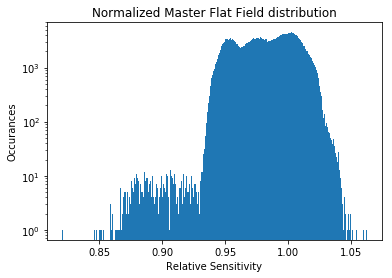

In [74]:
# Above histogram is from ds9
# Here, we can flatten that fit in python and sigma clip to quantify the dead pixels

normflat_counts = normflat.flatten()
nf_mean = np.mean(normflat_counts)
nf_sd = np.std(normflat_counts)

plt.hist(normflat_counts,bins=1000);
plt.yscale('log')
plt.xlabel('Relative Sensitivity')
plt.ylabel('Occurances')
plt.title('Normalized Master Flat Field distribution');

The distribution is fairly Guassian with outliers toward the lower end of the relative sensitivity range. 

One problem that may occur with CCDs is that it may have dead-pixels. These are pixels that give no counts regardless of the incident signal. There are easily identifiable as they will register zero counts. However, we can use a looser definition. After sigma clipping the master flat-field, we will classify the lower-end outliers as dead pixels. 

In [75]:
dead_cut = nf_mean - 3*nf_sd  #pixels with counts at or lower this are 'dead'

### (4.3.4-5)

As mentioned, vignetting will cause pixels toward the edge of the image to receive less light. Pixels in the centre of the image will receive the full brightness and therefore will have a higher relative sensitivity. To quantify how the sensitivity changes as you move from the centre of the image toward the edge, we can plot the sensitivity as a function of distance from the centre. 

To do so, we can draw projections across the image in ds9 from the center to each edge then average them. 

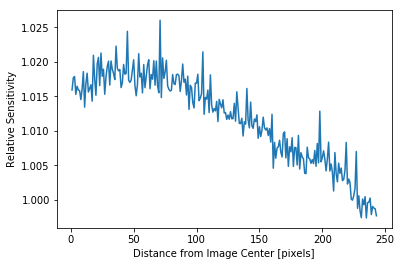

In [76]:
# opening the data from the projections
file1 = open('center_to_top.dat')
file2 = open('center_to_right.dat')
file3 = open('center_to_bottom.dat')
file4 = open('center_to_left.dat')

list = []
for line in file1:
        list += [line.split()]
xtop = [float(x[0]) for x in list]  # x = distance from center
ytop = [float(x[1]) for x in list]  # y = relative sensitivity
list = []
for line in file2:
        list += [line.split()]
xright = [float(x[0]) for x in list]
yright = [float(x[1]) for x in list]
list = []
for line in file3:
        list += [line.split()]
xbottom = [float(x[0]) for x in list]
ybottom = [float(x[1]) for x in list]
list = []
for line in file4:
        list += [line.split()]
xleft = [float(x[0]) for x in list]
yleft = [float(x[1]) for x in list]
file1.close()
file2.close()
file3.close()
file4.close()

# arrays are not the same size due to inexact projections 
#  drawn on ds9, so they must be truncated to the same size
xright = [xright[i] for i in range(0,len(xtop))]
yright = [yright[i] for i in range(0,len(ytop))]
xleft = [xleft[i] for i in range(0,len(xtop))]
yelft = [yleft[i] for i in range(0,len(ytop))]
# now creating a mean combine of the lists 
x_tot = []
y_tot = []
for i,val in enumerate(xtop):
        x = xtop[i]+xright[i]+xbottom[i]+xleft[i]
        y = ytop[i]+yright[i]+ybottom[i]+yleft[i]
        x_tot.append(x/4.0)
        y_tot.append(y/4.0)

# plotting the mean sets
plt.plot(x_tot,y_tot)
plt.xlabel('Distance from Image Center [pixels]')
plt.ylabel('Relative Sensitivity')
plt.show()

Clearly, the sensitivity is higher in the center of the image and decreases toward the edges. If the same star was moved from the center to one of the corners of the image, its 'observed' magnitude would decrease. Had we forgotten to take flat-fields on the night of observations, it would not be accurate to re-take them on a different night. The lighting and dust and camera conditions could have changed drastically over the course of a day and would affect the flat-fields taken on the next night differently than the science images were affected, resulting in an inaccurate correction. 

## (4.4.1)

Now that we have identified the hot and dead pixels, one might wonder how they are actually accounted for in the science images. This is done using a bad pixel map, essentially an image which marks which pixels are hot or dead. 

The pixel map is simple to construct since we have already defined the criteria for identifying hot pixels and dead pixels. We start with an array that is the same size as our images where each value is set to equal 1. The hot pixels were identified in the master dark frame. We then loop through each pixel in the master dark; if the count at that pixel does not pass the hot pixel cut, that corresponding position in the map is set to zero. The same is done looping through the master flat-field with the dead pixel cut criteria. The result is an array of 1s and 0s, where a value of 0 indicates a bad pixel at that position.

In [77]:
# Working on making the bad pixel map

#hot pixels identified through sigma clipping of master dark frame in 4.2.1
md_array = np.median(all_dark,axis=0)  # median combined master dark - array form
hot_cut = mdf_mode + 3*mdf_sd          # mode and s.d. calculated in 4.2.1

map = md_array*0
map += 1          # array of 1s to identify marked pixels
for i,list in enumerate(md_array):
    for j,value in enumerate(list):
        if value >= hot_cut: #if the count > hot pixel cut-off, sets the corresponding 
            map[i,j] = 0     # spot in the map to 0 

# master flat field array is 'normflat'
# we defined dead_cut above
for i,list in enumerate(normflat):
    for j,value in enumerate(list):
        if value <= dead_cut: # if the count < dead pixel cut-off, sets the corresponding spot
            map[i,j] = 0      #   in the map to 0
            
print(map)
# writing the map to a .fits
#mapfit = fits.PrimaryHDU(map)
#mapfit.writeto('pixelmap.FIT')

[[0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 0.]]


## (4.4.2)

Rewriting this array to a new FIT file, we can view the map as an image.

![alt text](pixelmap.png)

The bad pixels have count of zero and are represented by the black pixels on the image. The good pixels are all white, having a count of one. 

In a subsequent analysis, we can use this map to eliminate the corresponding pixels on our science images. This will give more accurate counts in an aperture area and therefore more accurate flux readings. 

## (4.5.1)

We have now finished the calibration steps for the STL-1001 imaging camera. Additional calibration must be done for spectroscopy. The spectrograph requires a different camera: the ST-402 CCD. Before connecting to the camera, however, the spectrograph must be focused. 

The spectrograph was assembled with its 20mm eyepiece attached. A neon calibration lamp was attached. The neon emission spectrum has a bright and easily identifiable yellow line at 5852.48 Angstroms. Looking through the eyepiece, the spectrograph was focused and the angle of the diffraction grating were adjusted until this line was located. We positioned this line toward the 'blue' end of the spectrum so that we could have a valid sample of the redder emission lines as well. 

Once this was done, the spectrograph was connected to the ST-402. To take a flat-field spectrum, the assembly was attached to the telescope. 

![alt text](specflat.png)

Shown is the flat-field spectrum, taken on the interior of our telescope dome. The bottom spectrum on the image corresponds to the 50 $\mu$m width slit of the spectrograph. 


## (4.5.2)
We are only interested in the 50 $\mu$m slit for this analysis. The flat-field is taken a uniformly illuminated surface, but may exhibit non-uniform features along its spectrum. To test this, we can plot the flat-field values along the dispersion axis (horizontal on the image) of the slit. 

There may be effects like vignetting along the width of the slit that impact the count value. To account for this, we divide the slit into 5 projection lines shown as the green lines here:

![alt text](specflat_divisions.png)

The flat-field values versus pixel position along each line is recorded. We then average the five sets. 

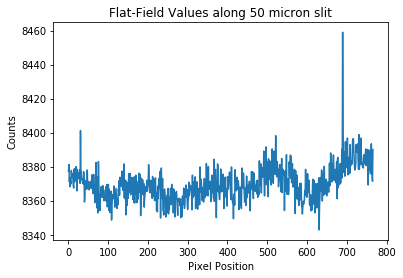

In [78]:
p1_data = open('specflat_d1.dat')
p2_data = open('specflat_d2.dat')
p3_data = open('specflat_d3.dat')
p4_data = open('specflat_d4.dat')
p5_data = open('specflat_d5.dat')

def get_data(data):  #returns x and y columns from data set
    list = []
    for line in data:
        list += [line.split()]
    x = [float(x[0]) for x in list] #pixel position across the slit
    y = [float(x[1]) for x in list] #count values
    return x,y

x1,y1 = get_data(p1_data)
x2,y2 = get_data(p2_data)
x3,y3 = get_data(p3_data)
x4,y4 = get_data(p4_data)
x5,y5 = get_data(p5_data)

x = []  # the averages of the sets
y = []
for i,value in enumerate(x1):
    xavg = (x1[i]+x2[i]+x3[i]+x4[i]+x5[i])/5
    yavg = (y1[i]+y2[i]+y3[i]+y4[i]+y5[i])/5
    x.append(xavg)
    y.append(yavg)
    
plt.plot(x,y)
plt.xlabel('Pixel Position')
plt.ylabel('Counts')
plt.title('Flat-Field Values along 50 micron slit')
plt.show()

The count values have an amount of variation along the whole dispersion axis, meaning there is variation with wavelength. This may be due to non-uniform sensitivity of the CCD/spectrograph or varition in the spectrum of the flat-field object itself. 

At this point, we can not discern between these two possible sources but normalizing the flat-field spectrum can provide clues. If there is variation due to pixel-to-pixel sensitivity, it will be reflected on small pixel position scales after normalization. Variation within the intrinsic spectrum will only be apparent on larger scales but is more difficult to conclusively identify. 

The flat-field counts seem to hover about some central value which seems to slightly increase along the dispersion axis. Therefore, instead of normalizing with the mean, it is more accurate to fit a polynomial to the spectrum. 

## (4.5.3)

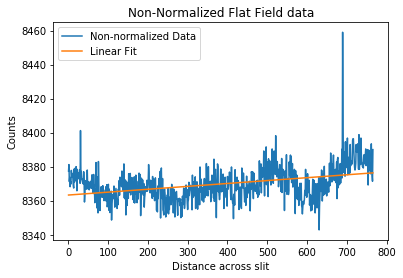

In [79]:
#fitting a first-order polynomial to do normalization
m,b = np.polyfit(x,y,1)
y_fit = [m*xval+b for xval in x]

#plotting the data before normalization with the line fitted to it
plt.plot(x,y,label='Non-normalized Data')
plt.plot(x,y_fit,label='Linear Fit')
plt.title('Non-Normalized Flat Field data')
plt.xlabel('Distance across slit')
plt.ylabel('Counts')
plt.legend(loc='best')
plt.show()



The orange line represents the first order polynomial fitted to the spectrum. We see it does indeed have a positive slope, increasing along the dispersion axis. To normalize the spectrum around 1.0, we'll divide by this fit.

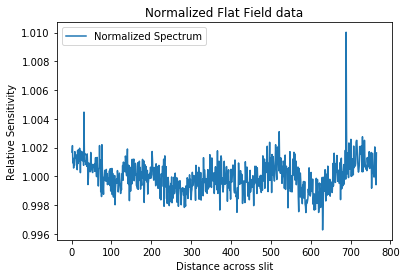

In [80]:
#now doing the normalization 
norm_y = []

for i,yval in enumerate(y):
    n = yval/y_fit[i]
    norm_y.append(n)
    
plt.plot(x,norm_y,label='Normalized Spectrum')
plt.legend(loc='best')
plt.title('Normalized Flat Field data')
plt.xlabel('Distance across slit')
plt.ylabel('Relative Sensitivity')
plt.show()

This is now our normalized flat-field, plotted across the dispersion axis of the $50\mu m$ slit. 

In order to effectively use the spectrograph to determine the emission wavelengths our image, we have to know what pixel position along our spectrograph slit corresponds to what physical wavelength. To do so, we can derive a pixel position to wavelength calibration using an image of a known spectrum. For this, we'll use a neon calibration lamp. 

## (4.5.4)

The neon lamp was shined into the telescope and its spectrum imaged. The lamp spectrum must first be corrected for the sensitivity across the slit. This is done by applying our normalized flat-field to the lamp spectrum. 

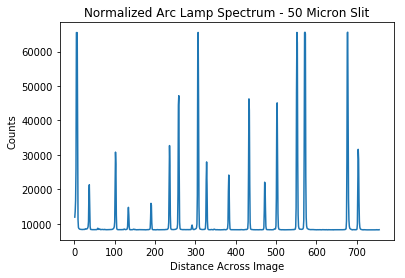

In [81]:
# opening data from lamp spectrum over 50 micron slit
lampdata = open('arcspec_50microndata.dat')

list = []
for line in lampdata:
    list += [line.split()]
    
x_lamp = [float(x[0]) for x in list]  #distance across image
y_lamp = [float(x[1]) for x in list]  #count average

# applying the normalized flat to the arc lamp spectrum
for i,xval in enumerate(x_lamp):
    y_lamp[i] = y_lamp[i]/norm_y[i]

#plotting the normalized spectrum; counts versus distance on image
plt.plot(x_lamp,y_lamp)
plt.title('Normalized Arc Lamp Spectrum - 50 Micron Slit')
plt.xlabel('Distance Across Image')
plt.ylabel('Counts')
plt.show()

We now have a spectrum of the calibration lamp normalized to account for the varying sensitivity across the spectrograph. It is plotted as the number of counts as a function of pixel position along the dispersion axis. We note that some emission lines have saturated count values of $\approx$ 65,000 counts.

## (4.5.5)

We can now convert the pixel position of each emission line to the physical wavelength of that line. We have a list of the physical wavelengths of the neon emission spectrum acquired from: http://www.astrosurf.com/buil/us/spe2/hresol4.htm

Plotting the physical emission wavelengths against the corresponding pixel positions of those emission lines should give a linear relationship between them. The linear fit of this will be our calibration.

Pixel Position	Wavelength [Angstrom]
6.0	 	5852.49
37.0	 	5881.89
102.0	 	5944.83
134.0	 	5975.53
190.0	 	6030
236.0	 	6074.34
259.0	 	6096.16
307.0	 	6143.06
328.0	 	6163.59
383.0	 	6217.28
433.0	 	6266.49
472.0	 	6304.79
503.0	 	6334.43
552.0	 	6382.99
572.0	 	6402.25
677.0	 	6506.53
704.0	 	6532.88


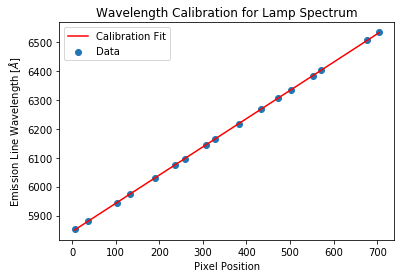

Wavelength calibration:
Wavelength =  0.975 * Pixel Position +  5844.82


In [82]:
# wavelengths of these lines, left to right, units [Angstrom]
# numbers taken from online source
emission_lam = [5852.49, 5881.89,5944.83,5975.53,6030,6074.34,6096.16,6143.06,6163.59,6217.28,6266.49,6304.79,6334.43,6382.99,6402.25,6506.53,6532.88] 
        
# x locations of the emission peaks    
x_lines = [6.0,37.0,102.0,134.0,190.0,236.0,259.0,307.0,328.0,383.0,433.0,472.0,503.0,552.0,572.0,677.0,704.0]

# making a table of the wavelength and distance on image
print('Pixel Position' + '\t' + 'Wavelength [Angstrom]')
for i,x in enumerate(x_lines):
    print(str(x) + '\t \t' + str(emission_lam[i]))

#performing a polynomial fit for calibration
eline_slope,eline_int = np.polyfit(x_lines,emission_lam,1)
y_eline_fit = [eline_slope*x+eline_int for x in x_lines]
# wavelength position = m*pixel_position + b

plt.scatter(x_lines,emission_lam,label='Data')
plt.plot(x_lines,y_eline_fit,color='red',label='Calibration Fit')
plt.xlabel('Pixel Position')
plt.ylabel('Emission Line Wavelength [$\AA$]')
plt.legend(loc='best')
plt.title('Wavelength Calibration for Lamp Spectrum')
plt.show()

print('Wavelength calibration:')
print('Wavelength = ','%.3f'%eline_slope,'* Pixel Position + ','%.2f'%eline_int)

This is our calibration between the emission wavelength and the corresponding pixel position along the spectrograph slit. 

## (4.5.6)

A spectrograph's dispersion is a measure of the wavelength interval over each pixel. We can determine the dispersion of our spectrograph using the lamp spectrum. To detemine the wavelength spectrum over a single pixel, we simply divide the range of wavelengths over the whole slit by the number of pixels over the whole slit. 

In [83]:

# dispersion is wavelength interval over a single pixel
max_lam = emission_lam[(len(emission_lam)-1)]  #largest wavelength peak
min_lam = emission_lam[0]                      #smallest wavelength peak
pix_interval = x_lines[(len(emission_lam)-1)] - x_lines[0]
dispersion = (max_lam - min_lam)/pix_interval  #Angstrom / pixels

print('dispersion = ','%.3f'%dispersion, ' Angstrom / pixel')
print('Length of spectrum treated', '%.2f'%(dispersion*pix_interval),' Angstroms')

dispersion =  0.975  Angstrom / pixel
Length of spectrum treated 680.39  Angstroms


## (4.5.7)
Having derived the calibration to convert pixel position to wavelength, we can apply this to the lamp spectrum.

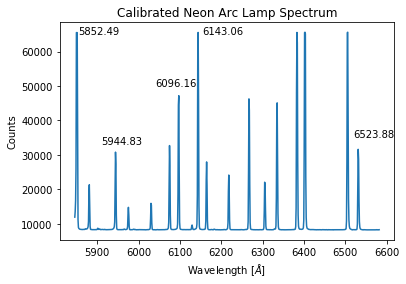

In [84]:
# Now we can get the calibrated spectrum put together
# position along x as the wavelength:
e_line_x= [eline_slope*x+eline_int for x in x_lamp]

#plotting the calibrated spectrum
plt.plot(e_line_x,y_lamp)
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Counts')
plt.title('Calibrated Neon Arc Lamp Spectrum')
plt.text(5855,65000,'5852.49')   #Labeling some of the emission lines
plt.text(5910,33000,'5944.83')
plt.text(6040,50000,'6096.16')
plt.text(6155,65000,'6143.06')
plt.text(6520,35000,'6523.88')

#writing the spectrum out to a .txt file
with open('arcspectrum_calibrated.txt','w') as file:
    file.write('Wavelength[Angstrom] \t Counts \n')
    for i,xval in enumerate(e_line_x):
        file.write(str(e_line_x[i]) + '\t' + str(y_lamp[i]) + '\n')

Here is our calibrated and normalized neon lamp spectrum with the counts plotted versus wavelength. We have labeled a few of the Neon emission lines and note that they match perfectly with that wavelength on the x-axis. 

## (4.6)

Our image calibration files include master bias frames, master dark frames, and master flat-fields. The first two, the bias and dark frames, are applied by subtracting them from the image. This subtracts out counts that are due to pixel bias level and dark current. The latter, the master flat-field, is applied by dividing it from the science image. This corrects each pixel for its relative sensitivity. The spectroscopy part of this experiment had an additional calibration file: the arc lamp spectrum. This was applied by fitting the wavelengths of known emission lines to their pixel position along the image.

It is crucial that flat-fields are taken with the same set up and on the same night as the science images. This is because the flat-fields are correcting for sensitivity which can be altered due to the presence of dust or external lighting, both of which can vary significantly over the course of waiting until the next day. On the other hand, dark and bias frames may be taken on the next day if absolutely necessary. Since these are closed-shutter images, the dust or external lighting is not a factor. We can assume that the properties of our CCD, such as its intrinsic bias level or the presence of dead pixels, do not change much over a short period of time. Therefore, these measurements would be the same whether taken on the same night as the science images or the next night. 